# Scorecard with binary target

In [81]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns
plt.style.use('ggplot')

pd.options.display.max_columns
pd.options.display.max_rows

60

In [2]:
from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

## Data import

In [65]:
df = pd.read_csv('heloc_dataset_v1.csv', sep=',')
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [9]:
variable_names = list(df.columns[1:])

## Check target variable for class imbalance

<AxesSubplot:xlabel='RiskPerformance', ylabel='count'>

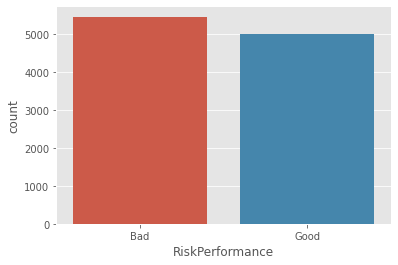

In [58]:
sns.countplot(data=df, x='RiskPerformance')

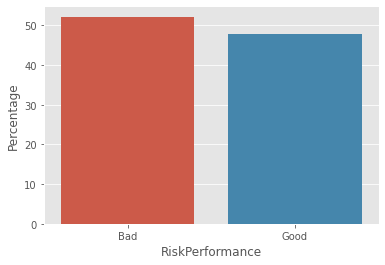

In [59]:
summary = pd.DataFrame(df['RiskPerformance'].value_counts(normalize=True)).reset_index()
summary.rename(columns={"index":"RiskPerformance", "RiskPerformance":"Percentage"}, inplace=True)
summary['Percentage'] = summary['Percentage'] * 100

sns.barplot(data=summary, x='RiskPerformance', y='Percentage');

## Transform the categorical dichotomic target variable into numerical

In [66]:
target = 'RiskPerformance'
y = df[target].values 
mask = y == "Bad"
y[mask] = 1 
y[~mask] = 0 
y = y.astype(int) 

df[target] = y
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,1,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,1,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,1,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,1,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [67]:
df[target].value_counts(normalize=True)

1    0.521943
0    0.478057
Name: RiskPerformance, dtype: float64

# Scorecard development

This dataset includes three special values/codes:

- -9 No Bureau Record or no investigation
- -8 No Usable/Valid Trades or inquiries 
- -7 Condition not met (e.g. no inquiries, no delinquencies)

In [68]:
special_codes = [-9, -8, -7]

We specify a selection criteria in terms of the Information Value (IV) predictiveness and minimum quality score to remove low-quality variables. Then, we instantiate a BinningProcess object class with variable names, special codes and selection criteria.

In [69]:
selection_criteria = {
    "iv": {"min":0.02, "max":1},
    "quality_score": {"min":0.01}
}

In [70]:
binning_process = BinningProcess(variable_names, 
                                    special_codes=special_codes,
                                    selection_criteria=selection_criteria)

We select an estimator of logistic regression to be solved using the non-linear solver L-BFGS-B

In [71]:
estimator = LogisticRegression(solver="lbfgs")

Finally, we instantiate a Scorecard class with the target name, a binning process object, and an estimator. In addition, we want to apply a scaling method to the scorecard points.

In [72]:
scorecard = Scorecard(target=target, 
                        binning_process=binning_process,
                        estimator=estimator,
                        scaling_method="min_max",
                        scaling_method_params={"min":300, "max":850})

In [73]:
scorecard.fit(df)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02},
                                                             'quality_score': {'min': 0.01}},
                                         special_codes=[-9, -8, -7],
                                         variable_names=['ExternalRiskEstimate',
                                                         'MSinceOldestTradeOpen',
                                                         'MSinceMostRecentTradeOpen',
                                                         'AverageMInFile',
                                                         'NumSatisfactoryTrades',
                                                         'NumTrades60Ever2DerogPubRec',
                                                         'NumTrades90Ever2DerogPubRec',
                                                         'PercentTradesNe...
                  

Similar to other objects in OptBinning, we can print overview information about the options settings, problems statistics, and the number of selected variables after the binning process. With these settings, using the selection criteria, 4 variables are removed.

In [78]:
scorecard.information(print_level=2)

optbinning (Version 0.10.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                   RiskPerformance   * U
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                  10459
    Number of variables                   23
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  0
    Number of selected                    19

  Timing
    Total time                          0.96 sec
    Binning process                     0.79 sec   ( 81.73%)
    Esti

The method table returns the scorecard table. A scorecard table has a wide range of real-world business applications, being an interpretable tool to summarize relationships among variables. The scorecard table can handle binary and continuous targets. Two scorecard styles are available: style="summary" shows the variable name, and their corresponding bins and assigned points; style="detailed" adds information from the corresponding binning table.

In [91]:
scorecard.table(style='summary')

,Variable,Bin,Points
0,ExternalRiskEstimate,"[-inf, 59.50)",5.359275
1,ExternalRiskEstimate,"[59.50, 63.50)",11.598078
2,ExternalRiskEstimate,"[63.50, 65.50)",18.168973
3,ExternalRiskEstimate,"[65.50, 67.50)",19.821705
4,ExternalRiskEstimate,"[67.50, 70.50)",25.498720
...,...,...,...
8,PercentTradesWBalance,"[80.50, 87.50)",32.310289
9,PercentTradesWBalance,"[87.50, 98.00)",32.026880
10,PercentTradesWBalance,"[98.00, inf)",31.928758
11,PercentTradesWBalance,Special,32.738612


In [90]:
sc = scorecard.table(style='summary')
sc.groupby("Variable").agg({'Points': [np.min, np.max]}).sum()

Points  amin    300.0
        amax    850.0
dtype: float64

# Scorecard performance

In [94]:
y_pred = scorecard.predict_proba(df)[:, 1]

## Plot area under the Receiver Operating Characteristic Curve (AUC ROC)

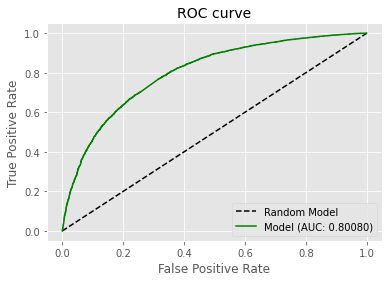

In [95]:
plot_auc_roc(df[target], y_pred)

## Plot Cumulative Accuracy Profile (CAP)

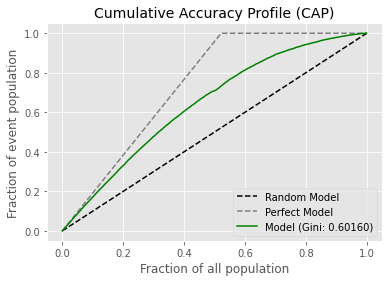

In [97]:
plot_cap(df[target], y_pred)

## Plot Kolmogorov-Smirnov (KS)

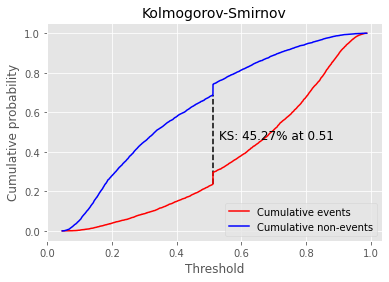

In [98]:
plot_ks(df[target], y_pred)

### Calculate the score of the dataset and plot distribution of scores for event and non-event records

In [100]:
score = scorecard.score(df)

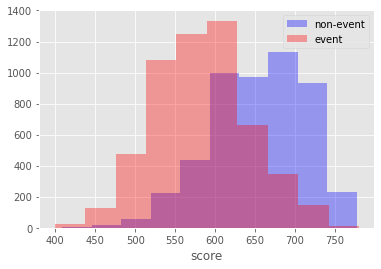

In [104]:
mask =df[target] == 0
plt.hist(score[mask], label='non-event', color='b', alpha=0.35)
plt.hist(score[~mask], label='event', color='r', alpha=0.35)
plt.xlabel('score')
plt.legend()
plt.show()